In [1]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked,words2words_hashblank,words2answers
from utils_NLP import words2text
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields
from utils_NLP import allenNLP_classify_blanks,allenNLP_classify_blanks_fromResults

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2

# Stats saving stuff
from utils_EDA import calcstats_train_dev

# AllenNLP stuff
from allennlp.predictors import Predictor

# Include custom AllenNLP
import myallennlp
from myallennlp import *
from myallennlp.models.simple_tagger2 import SimpleTagger2
from myallennlp.dataset_readers import sequence_tagging2
from myallennlp.data.tokenizers.word_splitter import SpacyWordSplitter

# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Function definitions

In [3]:

def calc_fracblanked(words,tags):
    # Pseudocode
    # For each answer, loop through the words and count the number of times it occurs.
    # Get the set of blanks booleans associated with each occurrence of that words, and calculate the
    # mean. Will do this for each word in the article, and then each article in the corpus. For each
    # article, rank the words by their proximity to 50 % 
    myanswers_unique = list(set(words2answers(words,tags)))

    fracblanked = []
    numblanked = []
    for ans in myanswers_unique:
        indices = [i for i, w in enumerate(words) if w == ans]
        tags_curr = [tags[i] for i in indices]
        #words_curr = [words[i] for i in indices]
        fracblanked.append(sum(tags_curr)/len(tags_curr)*100)
        numblanked.append(len(tags_curr))
        
    return fracblanked,numblanked,myanswers_unique;


def calc_grammatical_tags_dict(words,tags):
    # Builds a dictionary that contains all of the words, classification tags (blank/nonblnk),
    # and corresponding Spacy tags (parts of speech, ner, etc)

    # Use whitespace tokenizer (https://spacy.io/usage/linguistic-features)
    # davedit
    from spacy.tokens import Doc
    class WhitespaceTokenizer(object):

        def __init__(self, vocab):
            self.vocab = vocab

        def __call__(self, text):
            words = text.split(' ')
            # All tokens 'own' a subsequent space character in this tokenizer
            spaces = [True] * len(words)
            return Doc(self.vocab, words=words, spaces=spaces)

    import spacy

    nlp = spacy.load('en_core_web_sm')
    nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)
    doc = nlp(' '.join(words))
    # doc = nlp(words2text(words))

    pos=[]
    ner=[]
    dep=[]
    for token in doc:
        pos.append(token.pos_)
        ner.append(token.ent_type_)
        dep.append(token.dep_)

    # Build a dataframe to store everything
    d = {'ind': range(len(words)),
         'words' : words,
        'tags':tags,
        'pos':pos,
        'ner':ner,
        'dep':dep}

#     for k in d.keys():
#         print(str(len(d[k])))

    return d


# Load and merge ground truth and MODEL data

In [4]:
!pwd

/home/davestanley/Dropbox/git/mindpocket/train_model/articles_batch5.0/entropy_90_10_model6e0c37


In [5]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

In [6]:
# Trim down newly loaded articles to match Narticles in training set
ind_train = slice(0,Ntrain)
ind_dev = slice(0,Ndev)

# Chosen display articles
# From train
ind_ex = 1                   # Example from training set - Chopin
ind_ex = 381                   # Example from training set - Roman Republic
ind_ex = 213                   # Example from training set - Data compression
# ind_ex = 105                   # Pitch

# From dev
ind_ex = Ntrain + (467-442)    # Example from dev set - Immune system
ind_ex = Ntrain + (458-442)    # Example from dev set - Pharmacy
ind_ex = Ntrain + (456-442)    # Example from dev set - Black death

print(arts[ind_ex]['title'])

Black_Death


In [7]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
# print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


In [8]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
if not sum(titles_match_bool) == len(titles_match_bool):
    raise ValueError('Articles mismatch.')


Matching titles: 477 
Total articles 477


In [9]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [10]:
arts[ind_ex]['paragraphs'][0]['context']

"The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60% of Europe's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th century. The world population as a whole did not recover to pre-plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century."

In [11]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'

arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [12]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
    if not sum(titles_match_bool) == len(titles_match_bool):
        raise ValueError('Articles mismatch.')

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [13]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [14]:
# Pull out sample paragraph
p = arts[ind_ex]['paragraphs'][0]

## AllenNLP Words

In [15]:
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

131
131
The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th century. The world population as a whole did not recover to pre - plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century.
706


## Context

In [16]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


131
The Black Death is thought to have originated in the arid plains of Central Asia, where it then travelled along the Silk Road, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th century. The world population as a whole did not recover to pre - plague levels until the 17th century. The plague recurred occasionally in Europe until the 19th century.
706


## Context_blanked

In [17]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

131
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
The Black Death is thought to have originated in the arid plains of ______ ______ , where it then travelled along the ______ ______ , reaching Crimea by 1343 . From there , it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on ______ ______ . Spreading throughout the Mediterranean and Europe , the Black Death is estimated to have killed 30–60 % of Europe 's total population . In total , the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th ______ . The world population as a whole did not recover to pre - plague levels until the ______ ______ . The plague recurred occasionally in Europe until the ______ ______ .


In [18]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

Central
Asia
Silk
Road
merchant
ships
century
17th
century
19th
century


# Single paragraph - Compare blanks

## First, just look at the raw text

In [19]:
# Pull out sample paragraph
p = arts[ind_ex]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [20]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 131. Length ground truth blanks: 131


In [21]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
Black				______
Death				______
is				is
thought				thought
to				to
have				have
originated				originated
in				in
the				the
arid				______
plains				______
of				of
______				Central
______				Asia
,				,
where				where
it				it
then				then
travelled				travelled


## Ground truth blanked

In [22]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

The Black Death is thought to have originated in the arid plains of ______ ______, where it then travelled along the ______ ______, reaching Crimea by 1343. From there, it was most likely carried by Oriental rat fleas living on the black rats that were regular passengers on ______ ______. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated 450 million down to 350–375 million in the 14th ______. The world population as a whole did not recover to pre - plague levels until the ______ ______. The plague recurred occasionally in Europe until the ______ ______.
Answers:
['Central', 'Asia', 'Silk', 'Road', 'merchant', 'ships', 'century', '17th', 'century', '19th', 'century']


In [23]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

The ______ ______ is thought to have originated in the ______ ______ of Central Asia, where it then travelled along the ______ ______, reaching Crimea by ______. From there, it was most likely carried by Oriental ______ ______ living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated ______ ______ down to ______ ______ in the 14th century. The world population as a whole did not recover to pre - plague levels until the ______ ______. The plague recurred occasionally in Europe until the 19th century.
Answers:
['Black', 'Death', 'arid', 'plains', 'Silk', 'Road', '1343', 'rat', 'fleas', '450', 'million', '350–375', 'million', '17th', 'century']


In [24]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [25]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.8625954198473282
0.8625954198473282
4
11


In [26]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [27]:
print(TPR)
print(FPR)

0.36363636363636365
0.09166666666666666


In [28]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=6
Nsentences_from_words=6


In [29]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.6666666666666666
1.8333333333333333


# Single article - compare blanks

In [30]:
##### Pull out sample paragraph
a = arts[ind_ex]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Black_Death


In [31]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 3683. Length ground truth blanks: 3683


In [32]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=30
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
print("Original" + '\t\t\t' + "Ground truth" + '\t\t\t' + "Prediction")
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
for o,c,w in zip(words[:N],words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(o + '\t\t\t\t' + c + '\t\t\t\t' + w)


========			============			==========
Original			Ground truth			Prediction
========			============			==========
The				The				The
Black				Black				______
Death				Death				______
is				is				is
thought				thought				thought
to				to				to
have				have				have
originated				originated				originated
in				in				in
the				the				the
arid				arid				______
plains				plains				______
of				of				of
Central				______				Central
Asia				______				Asia
,				,				,
where				where				where
it				it				it
then				then				then
travelled				travelled				travelled
along				along				along
the				the				the
Silk				______				______
Road				______				______
,				,				,
reaching				reaching				reaching
Crimea				Crimea				Crimea
by				by				by
1343				1343				______
.				.				.


In [33]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [34]:
print(ACC)
print(ACC2)

0.8810752104262829
0.8810752104262829


In [35]:
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)


In [36]:
# print(TPR)
# print(FPR)

In [37]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=126


In [38]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.7301587301587301
2.9206349206349205


## Ground truth blanked vs predicted blanked

In [39]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'1665', 'figures', 'areas', '15', '17th', 'plague', 'Asia', '95', 'Italian', 'rats', 'faster', '100,000', 'account', '80', 'infected', 'northwestern', 'corpses', '100–106', 'Plague', 'Central', 'Half', 'fleas', 'branches', 'Gasquet', '1331', 'China', 'Justinian', 'atra', '1347', 'present', '40,000', 'merchant', 'million', '1338–39', 'J.I.', 'bubonic', 'Pontanus', 'north', 'bad', 'mors', 'king', 'air', 'isolated', 'Yersinia', 'percent', '25', '2010', 'northwest', 'spring', '1377', 'Beg', 'clergy', '90', 'Sicily', '2011', 'France', 'Alexandre', 'Silk', 'autumn', 'pestis', 'half', 'marginal', 'England', 'Road', '1720', '1349', 'Jani', 'genetic', 'Genoese', '1908', 'anthrax', '1350', 'much', 'October', 'significance', '1500', 'trade', 'dating', 'ships', '1654', '38–41', '1823', '1.7', 'Scandinavia', 'Kong', '19th', 'Miasma', 'form', 'third', 'confirmed', 'Smithfield', 'population', 'Y.', 'amended', 'commonly', 'century', '5', '1850', 'Russia', 'Constantinople', 'traders', '22', '

In [40]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'infections', 'typhus', '1894', 'Hanseatic', '1665', 'Tudor', 'June', 'endemic', '1.25', 'medical', 'Spain', '1893', 'rural', 'plague', '17th', 'Cantor', '1679', 'septicemic', '95', 'Norway', '1346', 'western', 'rats', 'Egypt', 'region', 'Middle', 'smallpox', 'untreated', 'depopulation', 'Islamic', 'London', '1629–1631', '100,000', 'infection', 'Mediterranean', 'rat', '80', 'Septicemic', 'epidemic', 'northwestern', 'famine', 'Plague', 'Europe', 'buboes', '1348–50', '1345', 'enzootic', 'transmission', 'clades', 'pestilence', 'fleas', 'airborne', 'recurrence', '1466', 'Askøy', 'branches', '1348', 'Gasquet', 'red', '541', '1750', '14th', 'China', '1331', 'tooth', '1649', 'Justinian', 'atra', 'Britain', '1347', '40,000', 'Africa', 'Mongol', 'Low', '1671', '1479–80', 'million', 'survival', 'David', 'Herlihy', 'Florence', 'three', 'high', 'Bjørgvin', 'J.I.', 'bubonic', 'Uganda', '1701', 'Pontanus', 'Paris', 'bad', 'bright', 'mors', 'king', 'respiratory', 'air', 'sockets', '15th', '

## Fract of answers blanked

### Fract answers blanked vs num answers

In [41]:
fracblanked,numblanked,myanswers_unique = calc_fracblanked(words,tags)

Text(0, 0.5, 'Num occurrences')

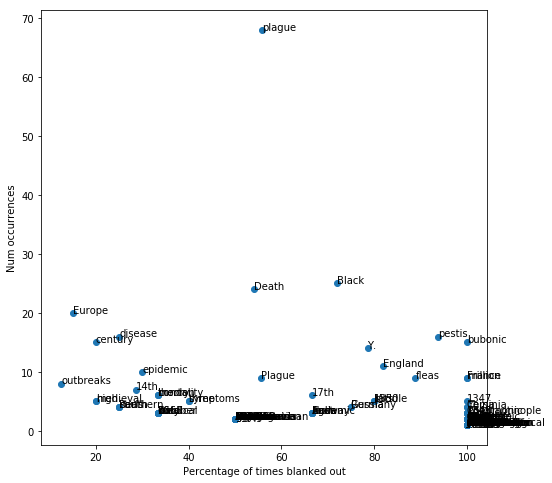

In [42]:
# Do scatter plot
y = numblanked
z = fracblanked
n = myanswers_unique

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
plt.xlabel('Percentage of times blanked out')
plt.ylabel('Num occurrences')

### Fract answers blanked for all answers

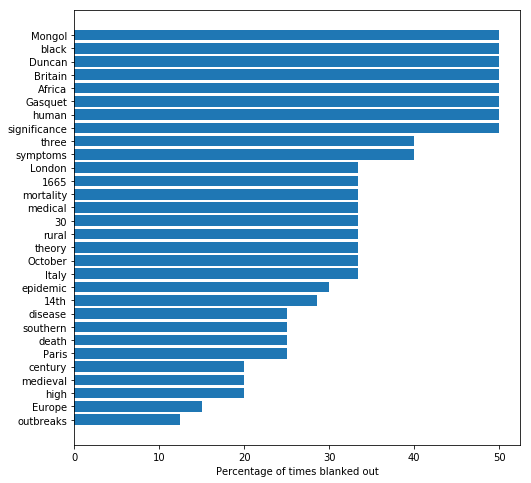

In [43]:
import numpy as np
import pandas as pd

d = {'myanswers_unique':myanswers_unique,'fracblanked':fracblanked}

df = pd.DataFrame(data=d);

df2 = df.sort_values(by='fracblanked',ascending=True);



N=30          # of data points to show
figure(num=None, figsize=(8, 8),facecolor='w', edgecolor='k')
bars = (df2['myanswers_unique'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
val = (df2['fracblanked'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('Percentage of times blanked out')
# Show graphic
plt.show()



### Fractions of NER tags blanked

In [44]:
d = calc_grammatical_tags_dict(words,tags)

In [45]:
df = pd.DataFrame(data=d)
xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['ner']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)

        

In [46]:
df3 = df.loc[df['ner'] == 'PERSON']
df3.head()           # Hmmm

,ind,words,tags,pos,ner,dep
319,319,Constantinople,1,PROPN,PERSON,dobj
356,356,Jani,1,PROPN,PERSON,compound
357,357,Beg,1,PROPN,PERSON,pobj
489,489,Bjørgvin,1,PROPN,PERSON,pobj
616,616,Constantinople,1,PROPN,PERSON,pobj


In [47]:
df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

,xlabs,yvals
14,NER: ordinal,0.000000
13,NER: money,0.000000
0,NER:,6.606082
6,NER: percent,8.000000
16,NER: law,16.666667
1,NER: loc,22.033898
9,NER: cardinal,24.210526
8,NER: date,29.218107
3,NER: quantity,33.333333
12,NER: product,33.333333


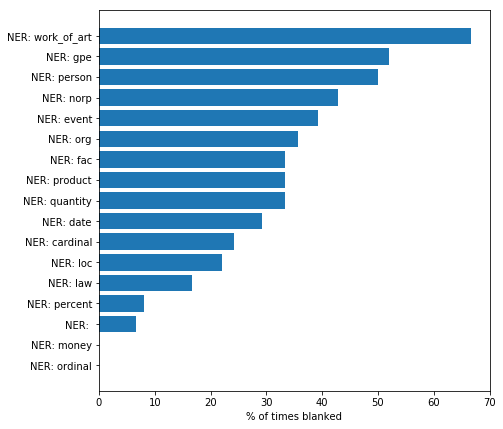

In [48]:
figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


### Fractions of POS tags blanked

In [49]:
df = pd.DataFrame(data=d)
xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['pos']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)

        

In [50]:
df3 = df.loc[df['pos'] == 'PROPN']
df3.head()           # Hmmm

,ind,words,tags,pos,ner,dep
1,1,Black,1,PROPN,EVENT,compound
2,2,Death,1,PROPN,EVENT,nsubjpass
13,13,Central,0,PROPN,LOC,compound
14,14,Asia,0,PROPN,LOC,pobj
22,22,Silk,1,PROPN,FAC,compound


In [51]:
df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

,xlabs,yvals
1,POS: x,0.000000
4,POS: cconj,0.000000
5,POS: part,0.000000
6,POS: det,0.000000
7,POS: pron,0.000000
8,POS: sym,0.000000
13,POS: punct,0.000000
12,POS: adp,0.173010
10,POS: verb,0.691244
0,POS: adv,0.714286


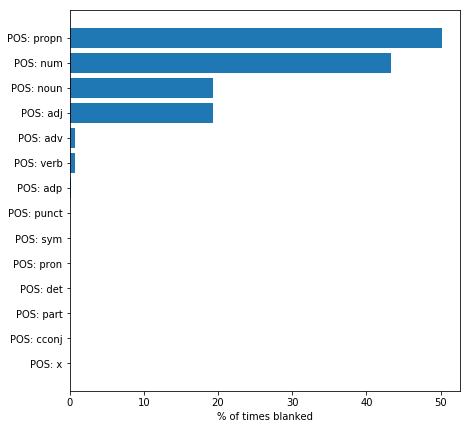

In [52]:
figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


## Whole article

### Ground truth

In [53]:

# print('--------------- GROUND TRUTH ---------------')

# # Pull out sample paragraph
# for p in arts[ind_ex]['paragraphs']:
#     # # Print all AllenNLP classifications
#     # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

#     # AllenNLP results
#     words = p['allenNER']['words'].split()
#     # tags = p['allenNER']['tags'].split()
#     # tags = [not t == '0' for t in tags]   # Convert to binary
#     tags = p['blank_classified_allen']

#     # Ground truth
#     blank_classification = p['blank_classification']

#     words_blanked_ground_truth = words2words_blanked(words,blank_classification)
#     words_blanked_allen = words2words_blanked(words,tags)
#     words_hash_ground_truth = words2words_hashblank(words,blank_classification)
#     words_hash_allen = words2words_hashblank(words,tags)
    
    
#     # Blanked text
#     print(words2text(words_hash_ground_truth))

#     # Answers    
#     myanswers = words2answers(words,blank_classification)
#     print("Answers:")
#     print(myanswers)

    

### My model

In [54]:

print('--------------- MY MODEL ---------------')
# Pull out sample paragraph
for p in arts[ind_ex]['paragraphs']:
    # # Print all AllenNLP classifications
    # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

    # AllenNLP results
    words = p['allenNER']['words'].split()
    # tags = p['allenNER']['tags'].split()
    # tags = [not t == '0' for t in tags]   # Convert to binary
    tags = p['blank_classified_allen']

    # Ground truth
    blank_classification = p['blank_classification']

    words_blanked_ground_truth = words2words_blanked(words,blank_classification)
    words_blanked_allen = words2words_blanked(words,tags)
    words_hash_ground_truth = words2words_hashblank(words,blank_classification)
    words_hash_allen = words2words_hashblank(words,tags)
    
    # Blanked text
    print(words2text(words_hash_allen))

    # Answers    
    myanswers = list(set(words2answers(words,tags)))
    print("Answers:")
    print(myanswers)
    

    

--------------- MY MODEL ---------------
The ___Black___ ___Death___ is thought to have originated in the ___arid___ ___plains___ of Central Asia, where it then travelled along the ___Silk___ ___Road___, reaching Crimea by ___1343___. From there, it was most likely carried by Oriental ___rat___ ___fleas___ living on the black rats that were regular passengers on merchant ships. Spreading throughout the Mediterranean and Europe, the Black Death is estimated to have killed 30–60 % of Europe 's total population. In total, the plague reduced the world population from an estimated ___450___ ___million___ down to ___350–375___ ___million___ in the 14th century. The world population as a whole did not recover to pre - plague levels until the ___17th___ ___century___. The plague recurred occasionally in Europe until the 19th century.
Answers:
['Death', 'million', 'Silk', '450', '1343', 'century', 'Black', 'plains', 'rat', 'fleas', '350–375', 'arid', '17th', 'Road']
The ___plague___ disease, ca

# All articles - compare blanks

In [55]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads
sbc0 = []
st0 = []
Nwords0 = []

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))

    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))

        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100

        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2

    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    sbc0.append(sbc)
    st0.append(st)
    Nwords0.append(len(tags))

Warning article 175 contains 0 ground truth blanks and 268 tags. Likely bad
Warning article 440 contains 0 ground truth blanks and 348 tags. Likely bad
Warning article 441 contains 0 ground truth blanks and 645 tags. Likely bad


In [56]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

Bill_%26_Melinda_Gates_Foundation
Myocardial_infarction
Matter


In [57]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print('Ntrain={}'.format(str(Ntrain)))
print('Ndev={}'.format(str(Ndev)))
print('Ntrain_bad={}'.format(str(Ntrain_bad)))
print('Ndev_bad={}'.format(str(Ndev_bad)))




Ntrain=442
Ndev=35
Ntrain_bad=3
Ndev_bad=0


## Plot TPR

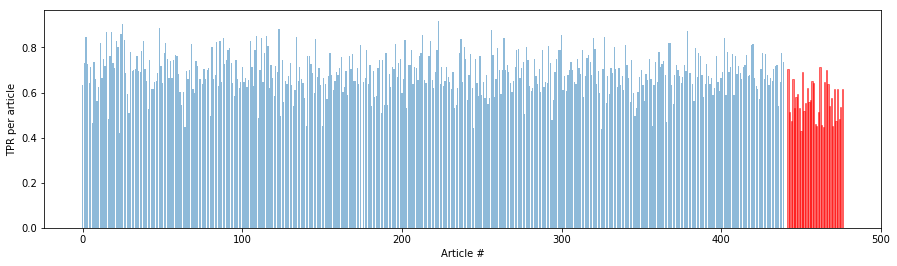

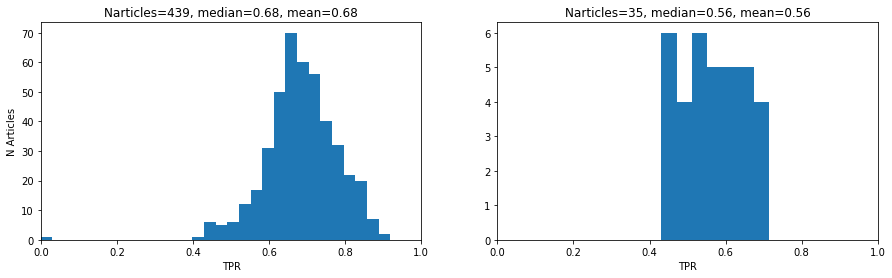

In [58]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot FPR

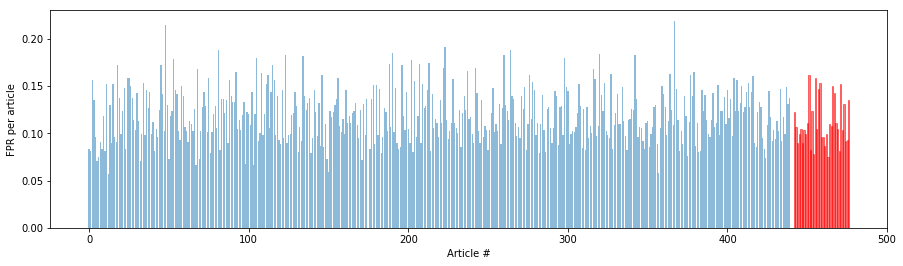

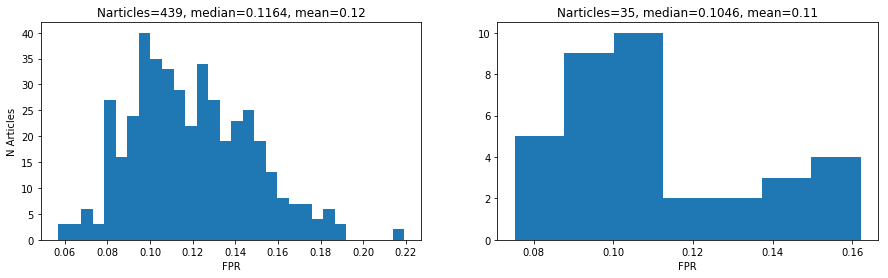

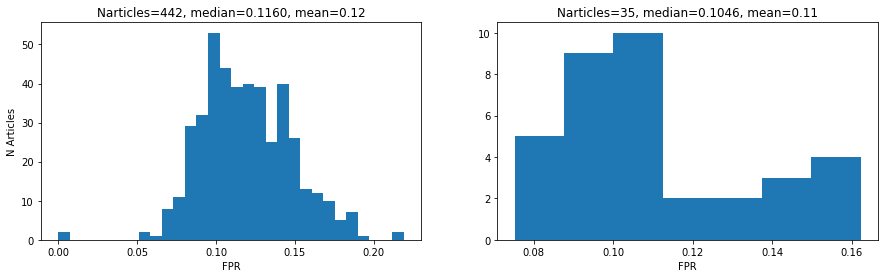

In [59]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# REdefine for plotting with with more decimal places
def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

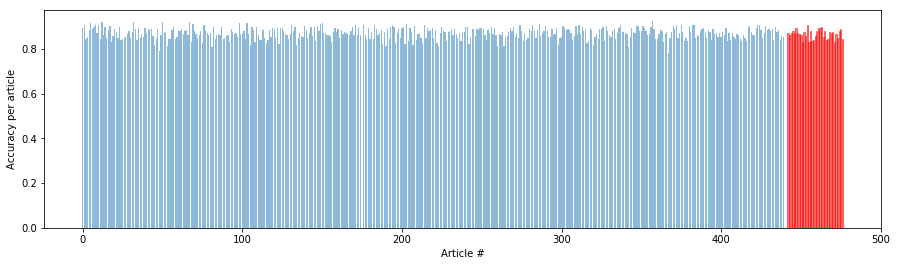

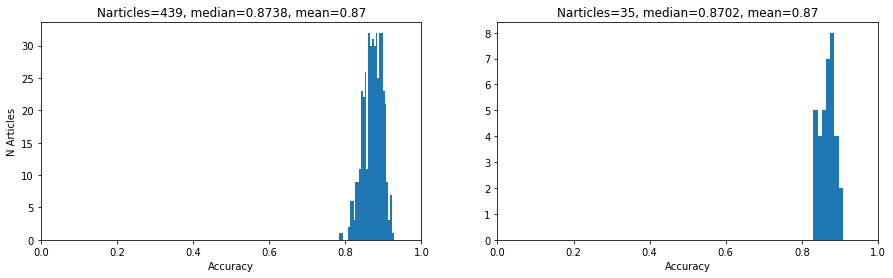

In [60]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

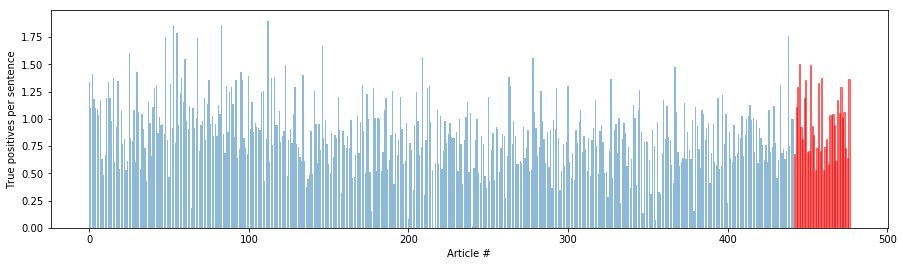

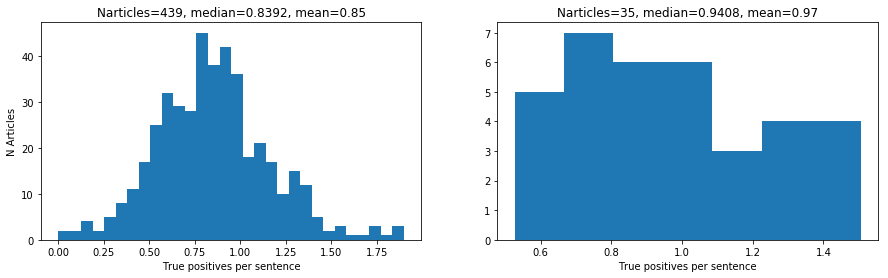

In [61]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

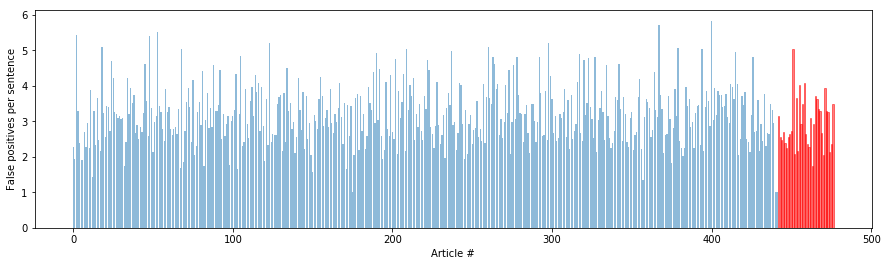

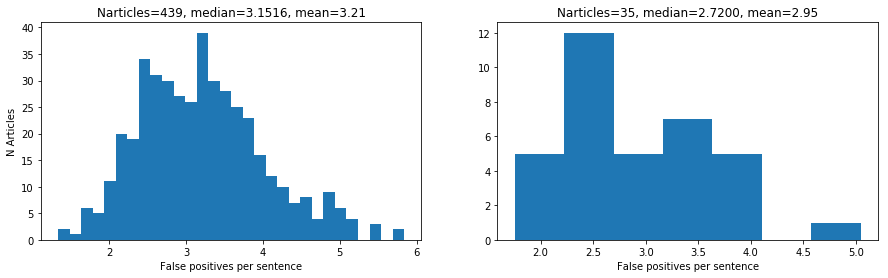

In [62]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [63]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

34
Article #476
Computational_complexity_theory
True positive rate: 0.5116279069767442


In [64]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Computational_complexity_theory


In [65]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				______
complexity				______
theory				theory
is				is
a				a
branch				branch
of				of
the				the
theory				theory
of				of
computation				______
in				in
theoretical				theoretical
computer				computer
science				science
that				that
focuses				focuses
on				on
classifying				classifying
______				______


## Ground truth blanked

In [66]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'yes', 'triples', 'rules', 'types', 'written', 'Algorithms', '21', 'knapsack', 'another', 'proper', '0', 'second', 'graph', 'matrices', 'gates', 'single', '1965', 'Presburger', 'NC', '2000', '1961', 'isomorphism', 'analysis', 'Yamada', 'memory', 'Manuel', 'language', 'input', 'PSPACE', 'statements', 'quicksort', 'classes', 'bound', 'algorithm', 'bitstrings', 'RSA', 'Turing', 'thesis', 'Myhill', 'triple', 'factorization', 'unequal', 'encoding', 'model', '1936', 'hierarchy', 'upper', 'worst', 'Complexity', 'reversed', 'quantum', 'Cobham', 'John', 'solution', 'complexity', 'quantitative', 'EXPTIME', 'deterministic', 'unusual', 'problems', 'Computational', 'abstract', 'complicated', 'branching', 'difficulty', 'machine', 'bits', 'output', 'taken', 'arbitrary', 'computability', 'definitions', 'space', 'level', 'reduces', 'Boolean', 'equal', 'algorithms', 'problem', 'instances', '1', 'polynomial', 'computation', 'P', 'transitions', 'L', 'probabilistic', 'alphabet', 'symbols', 'Hisao

In [67]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'yes', 'halts', 'triples', '2)1/3(log', 'intractability', 'M', '21', 'Algorithms', 'pivoting', 'knapsack', '0', 'satisfiability', 'computing', '15', 'respective', 'vertex', 'complement', '100', '×', 'sets', 'technological', 'C.', 'km', 'graph', 'n15', 'matrices', 'gates', 'decide', '1965', 'Cook', 'faster', 'Presburger', 'NC', 'finite', '2000', 'logarithm', 'concept', 'isomorphism', '1961', 'criteria', 'analysis', 'Yamada', 'Trakhtenbrot', 'language', 'Manuel', 'input', 'PSPACE', 'Combinatorial', 'paper', 'graphs', 'route', 'logarithmic', 'Boris', 'intuition', 'tree', 'relaxing', 'quicksort', '2n', 'respectively', 'classes', 'bounded', 'algorithm', 'bitstrings', 'reverse', 'isomorphic', 'f(n', 'RSA', 'round', 'Turing', 'thesis', 'Analogous', 'Myhill', 'order', 'triple', 'Π2', 'recast', 'consideration', 'BQP', 'factorization', 'b', 'unequal', 'encoding', 'expressed', 'cellular', 'average', '1936', 'utterance', 'O', 'FP', 'T(n', 'hierarchy', 'DTIME(n2', 'Leonid', 'three', 'leng

# All dev articles - fract Tags

In [68]:


# # Only train articles
# art = arts[0:Ntrain]


# Only dev articles
art = arts[Ntrain:]

print("Number of articles = {}".format(str(len(art))))

i=-1
words = []
tags = []
for a in art:
    i=i+1
    #print(a['title'])
    # AllenNLP results
    words = words + [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = tags + [t for p in a['paragraphs'] for t in p['blank_classified_allen']]


Number of articles = 35


In [69]:
d = calc_grammatical_tags_dict(words,tags)

### Fractions of POS tags blanked

In [70]:
df = pd.DataFrame(data=d)

df3 = df.loc[df['pos'] == 'PROPN']
print ('Lenth = {}'.format(str(len(df))))
print(df3.head())           # Hmmm

xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['pos']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)



Lenth = 176719
    ind     words  tags    pos     ner    dep
1     1   Normans     1  PROPN    NORP  nsubj
3     3    Norman     1  PROPN  PERSON   intj
7     7    French     1  PROPN    NORP   conj
13   13  Normanni     1  PROPN          appos
29   29  Normandy     1  PROPN  PERSON   pobj


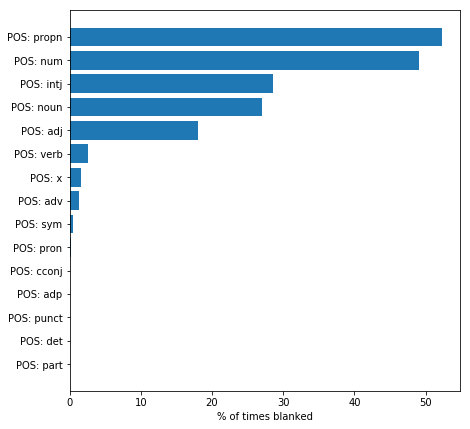

In [71]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


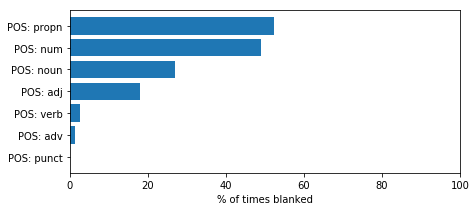

In [78]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

df = df.loc[(df['xlabs'] == 'POS: propn') | (df['xlabs'] == 'POS: adv')| (df['xlabs'] == 'POS: noun')| (df['xlabs'] == 'POS: verb')| (df['xlabs'] == 'POS: adj')| (df['xlabs'] == 'POS: num')| (df['xlabs'] == 'POS: punct')]

figure(num=None, figsize=(7,3),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
plt.xlim((0,100))
# Show graphic
plt.show()


### Fractions of NER tags blanked

In [80]:
df = pd.DataFrame(data=d)

df3 = df.loc[df['ner'] == 'PERSON']
print(df3.head())           # Hmmm

xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['ner']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)



    ind     words  tags    pos     ner       dep
3     3    Norman     1  PROPN  PERSON      intj
29   29  Normandy     1  PROPN  PERSON      pobj
40   40     Norse     1  PROPN  PERSON      pobj
65   65     Rollo     1  PROPN  PERSON     appos
73   73   Charles     0  PROPN  PERSON  compound


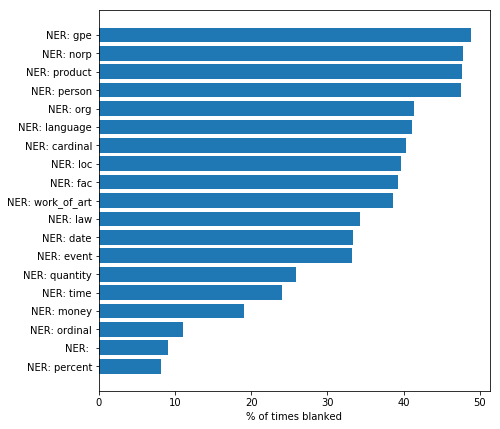

In [81]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


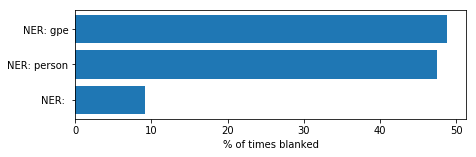

In [82]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

df = df.loc[(df['xlabs'] == 'NER: gpe') | (df['xlabs'] == 'NER: person') | (df['xlabs'] == 'NER: ')]


figure(num=None, figsize=(7,2),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


### Sum of POS tags blanked

In [86]:
df = pd.DataFrame(data=d)

df3 = df.loc[df['pos'] == 'PROPN']
print ('Lenth = {}'.format(str(len(df))))
print(df3.head())           # Hmmm

xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['pos']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum)



Lenth = 176719
    ind     words  tags    pos     ner    dep
1     1   Normans     1  PROPN    NORP  nsubj
3     3    Norman     1  PROPN  PERSON   intj
7     7    French     1  PROPN    NORP   conj
13   13  Normanni     1  PROPN          appos
29   29  Normandy     1  PROPN  PERSON   pobj


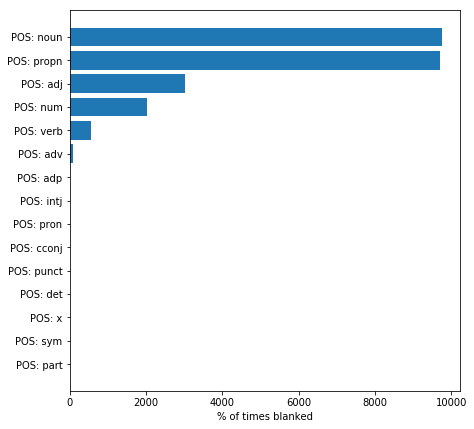

In [87]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


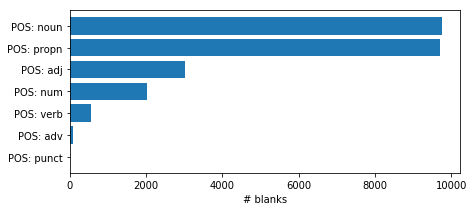

In [90]:


df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

df = df.loc[(df['xlabs'] == 'POS: propn') | (df['xlabs'] == 'POS: adv')| (df['xlabs'] == 'POS: noun')| (df['xlabs'] == 'POS: verb')| (df['xlabs'] == 'POS: adj')| (df['xlabs'] == 'POS: num')| (df['xlabs'] == 'POS: punct')]

figure(num=None, figsize=(7,3),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('# blanks')
# plt.xlim((0,100))
# Show graphic
plt.show()


# All paragraphs - compare blanks

In [74]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [75]:
FPR0[0:10]

[0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575,
 0.1354387107276575]

In [76]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [77]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


19035
1204
1383
13


## Plot TPR

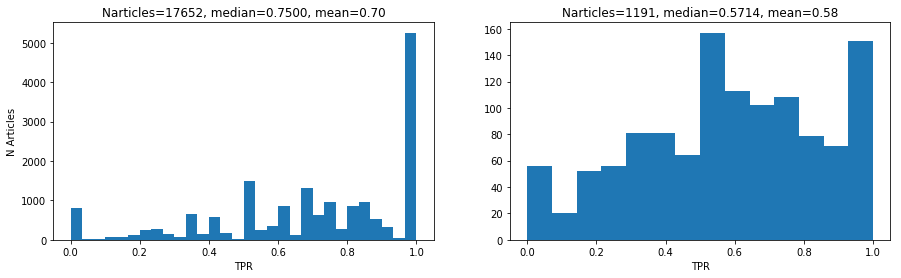

In [78]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [79]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

744
Article #442 paragraph #1
Normans
True positive rate: 0.8571428571428571


In [80]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [81]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
The				The
Norman				______
dynasty				______
had				had
a				a
major				major
political				political
,				,
cultural				cultural
and				and
military				military
impact				impact
on				on
medieval				medieval
Europe				Europe
and				and
even				even
the				the
Near				Near
East				______


## Ground truth blanked

In [82]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the ______ ______ into which they assimilated. They adopted the Gallo - Romance language of the Frankish land they settled, their dialect becoming known as Norman, Normaund or Norman French, an important literary language. The Duchy of Normandy, which they formed by treaty with the French crown, was a great fief of medieval France, and under ______ ______ of Normandy was forged into a cohesive and formidable principality in feudal tenure. The Normans are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. Norman adventurers founded the Kingdom of Sicily under Roger II after conquering southern Italy on the Saracens and Byzantines, and an expedition on

In [83]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

The ______ ______ had a major political, cultural and military impact on medieval Europe and even the Near ______. The ______ were famed for their martial spirit and eventually for their ______ ______, becoming exponents of the ______ ______ into which they assimilated. They adopted the ______ - Romance language of the ______ land they settled, their dialect becoming known as ______, ______ or ______ ______, an important literary language. The ______ of ______, which they formed by ______ with the ______ crown, was a great fief of ______ ______, and under ______ I of Normandy was forged into a cohesive and formidable principality in feudal tenure. The ______ are noted both for their culture, such as their unique Romanesque architecture and musical traditions, and for their significant military accomplishments and innovations. ______ adventurers founded the ______ of ______ under ______ ______ after conquering ______ ______ on the ______ and ______, and an ______ on behalf of their duke

In [84]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [85]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.8373015873015873
0.8373015873015873
6
40


In [86]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [87]:
print(TPR)
print(FPR)

0.8571428571428571
0.16326530612244897
